# Walmart store sales forecasting - [Kaggle](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview)

# Part 1 - Define

Provided the historical sales data for 45 Walmart stores located in different regions with each store containing many departments, we need to  project the sales for each department in each store. Additionally, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but we don't know which departments are affected and the extent of the impact.

In [3]:
# importing libraries

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools  import   grangercausalitytests
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import pickle
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
# author info
__author__ = "Sabareesh Mamidipaka"
__email__ = "sabareesh169@gmail.com"

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\sabareesh\Anaconda\lib\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\sabareesh\Anaconda\lib\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\sabareesh\Anaconda\lib\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\sabareesh\Anaconda\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\sabareesh\Anaconda\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.

During handling of the above exception, another exception occurred:

Traceback (m

TypeError: can only concatenate str (not "list") to str

# Part 2 - Discover

## Load the Data

In [2]:
#load the data into a Pandas dataframe

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

NameError: name 'pd' is not defined

## Examine the data

In [1]:
# Check the available features in each dataframe

train_data.head()
print()
print(train_data.isnull().any())

NameError: name 'train_data' is not defined

In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
test_data.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


## Clean Data

## Examine the feature types

In [8]:
train_data.info()

# Convert the date type from object to datetime
train_data.Date = pd.to_datetime(train_data.Date)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [9]:
train_data.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [10]:
features.info()

# Convert the date type from object to datetime
features.Date = pd.to_datetime(features.Date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


Text(0.5, 1.0, 'Markdown values over time')

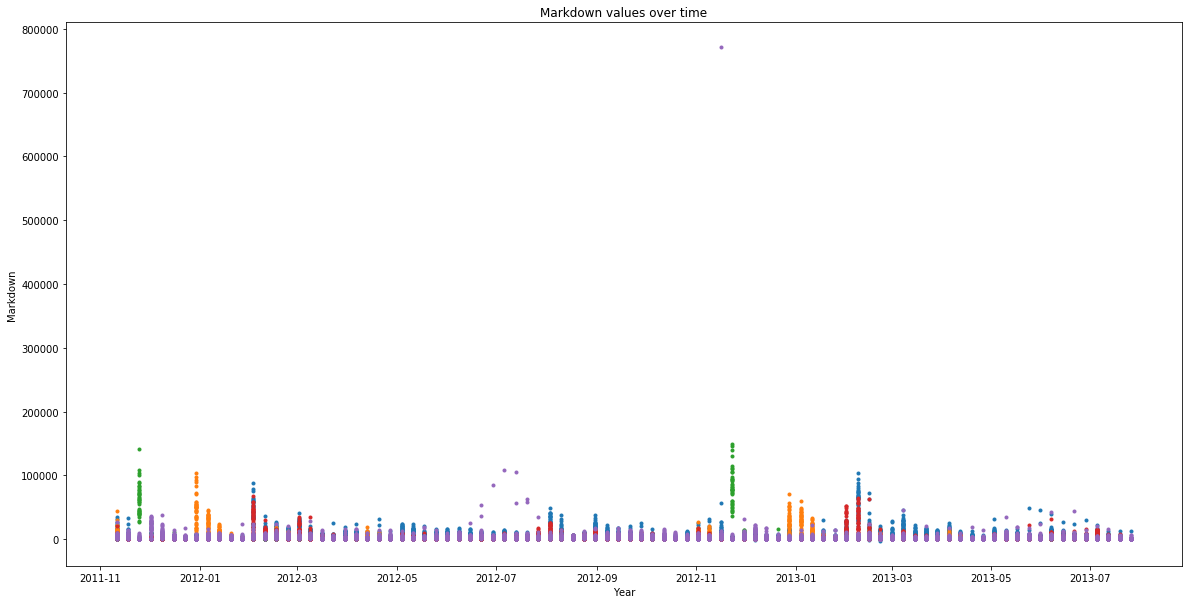

In [11]:
# There are lots of nan values in Markdowns. Fill them with 0's

#features.fillna(0)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(features['Date'], features['MarkDown1'], '.')
ax.plot(features['Date'], features['MarkDown2'], '.')
ax.plot(features['Date'], features['MarkDown3'], '.')
ax.plot(features['Date'], features['MarkDown4'], '.')
ax.plot(features['Date'], features['MarkDown5'], '.')
ax.set_xlabel('Year')
ax.set_ylabel('Markdown')
ax.set_title('Markdown values over time')

We can see that the Markdown values are not given for the first few years and only start from 2012.

Additionally, we have many Nan values for Markdown after 2012 too. MarkDown values mostly being repetitive annually
and because we dont have that data spanning over years, it doesn't make sense to include them as features.

In [12]:
# We will therefore neglect Markdown features from hereon.

del features['MarkDown1']
del features['MarkDown2']
del features['MarkDown3']
del features['MarkDown4']
del features['MarkDown5']

In [13]:
(features.groupby(['Store']).agg(['describe'])).Unemployment

# Unemployment is a factor which affects locally. So, any effect of unemployment should be on the store at that particular location.
# But from what we can see below, there doesnt seem to be much change in unemployment and its fairly constant in the period of analysis. 

describe                                                            
         count       mean       std    min     25%     50%     75%     max
Store                                                                     
1        169.0   7.440994  0.533324  6.314   6.908   7.742   7.838   8.106
2        169.0   7.403959  0.766789  6.112   6.565   7.852   8.099   8.324
3        169.0   7.006006  0.575426  5.999   6.334   7.343   7.551   7.574
4        169.0   5.647450  1.504749  3.879   4.077   5.644   7.127   8.623
5        169.0   6.163166  0.473794  5.278   5.603   6.465   6.529   6.768
6        169.0   6.412568  0.667641  5.285   5.668   6.855   6.973   7.259
7        169.0   8.378556  0.634100  6.953   7.872   8.595   8.963   9.137
8        169.0   5.947349  0.476915  5.024   5.401   6.262   6.299   6.433
9        169.0   5.929456  0.585250  4.893   5.277   6.380   6.415   6.560
10       169.0   8.137373  0.939997  6.791   7.170   8.257   9.003   9.765
11       169.0   7.006006  0.575426  5.999   6.334   7.343   7.551   7.574
12       169.0  12.637716  1.582713  9.874  10.926  13.503  14.021  14.313
13       169.0   6.762024  0.988794  5.274   5.765   6.877   7.795   8.316
14       169.0   8.640467  0.147398  8.335   8.523   8.625   8.724   8.992
15       169.0   7.994580  0.181061  7.658   7.806   8.036   8.150   8.350
16       169.0   6.335308  0.475070  5.324   6.061   6.338   6.842   7.039
17       169.0   6.365296  0.528823  5.213   5.936   6.617   6.745   6.885
18       169.0   8.712793  0.503033  7.788   8.243   8.890   9.202   9.342
19       169.0   7.994580  0.181061  7.658   7.806   8.036   8.150   8.350
20       169.0   7.368166  0.283039  6.961   7.191   7.293   7.484   8.187
21       169.0   7.403959  0.766789  6.112   6.565   7.852   8.099   8.324
22       169.0   7.963166  0.423916  7.176   7.543   8.023   8.348   8.572
23       169.0   4.668562  0.587278  3.684   4.145   4.584   5.287   5.892
24       169.0   8.481408  0.282563  8.117   8.252   8.358   8.693   8.983
25       169.0   7.368166  0.283039  6.961   7.191   7.293   7.484   8.187
26       169.0   7.749970  0.475346  6.884   7.405   7.767   8.149   8.512
27       169.0   7.990077  0.158889  7.697   7.850   8.000   8.058   8.253
28       169.0  12.637716  1.582713  9.874  10.926  13.503  14.021  14.313
29       169.0   9.681391  0.559624  8.780   9.140   9.863  10.160  10.524
30       169.0   7.403959  0.766789  6.112   6.565   7.852   8.099   8.324
31       169.0   7.403959  0.766789  6.112   6.565   7.852   8.099   8.324
32       169.0   8.378556  0.634100  6.953   7.872   8.595   8.963   9.137
33       169.0   8.269621  1.081681  6.698   7.147   8.442   9.265  10.115
34       169.0   9.772509  0.583911  8.796   9.285   9.653  10.210  10.641
35       169.0   8.757343  0.189227  8.360   8.665   8.745   8.861   9.262
36       169.0   7.617491  0.876214  6.143   6.623   8.177   8.395   8.554
37       169.0   7.617491  0.876214  6.143   6.623   8.177   8.395   8.554
38       169.0  12.637716  1.582713  9.874  10.926  13.503  14.021  14.313
39       169.0   7.617491  0.876214  6.143   6.623   8.177   8.395   8.554
40       169.0   4.668562  0.587278  3.684   4.145   4.584   5.287   5.892
41       169.0   6.807852  0.540390  5.639   6.432   6.901   7.335   7.541
42       169.0   8.137373  0.939997  6.791   7.170   8.257   9.003   9.765
43       169.0   9.772509  0.583911  8.796   9.285   9.653  10.210  10.641
44       169.0   6.475822  1.073313  4.872   5.407   6.560   7.610   8.119
45       169.0   8.640467  0.147398  8.335   8.523   8.625   8.724   8.992

In [14]:
# So, we neglect the feature from the analysis from now on.

del features['Unemployment']

In [15]:
(features.groupby(['Store']).agg(['describe'])).CPI

# CPI is also a factor which affects locally. So, any effect of CPI should be on the store at that particular location.
# But from what we can see below, there doesnt seem to be much change in CPI and its fairly constant in the period of analysis. 
# So, we neglect the feature from the analysis from now on.

describe                                                            \
         count        mean       std         min         25%         50%   
Store                                                                      
1        169.0  217.271679  5.004205  210.337426  211.746754  216.041053   
2        169.0  216.918640  4.994412  209.998458  211.404491  215.694438   
3        169.0  220.690122  5.099049  213.619614  215.060858  219.397287   
4        169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
5        169.0  217.844357  5.020091  210.887277  212.301952  216.603308   
6        169.0  218.838897  5.047682  211.842177  213.266137  217.579751   
7        169.0  194.718621  3.860194  189.381697  191.012180  194.741971   
8        169.0  220.737950  5.100376  213.665536  215.107226  219.444244   
9        169.0  220.926929  5.105621  213.846982  215.290437  219.629784   
10       169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
11       169.0  220.690122  5.099049  213.619614  215.060858  219.397287   
12       169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
13       169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
14       169.0  187.298763  4.078528  181.646815  182.764003  186.802400   
15       169.0  135.652333  2.554612  131.527903  132.817097  136.314500   
16       169.0  194.718621  3.860194  189.381697  191.012180  194.741971   
17       169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
18       169.0  135.652333  2.554612  131.527903  132.817097  136.314500   
19       169.0  135.652333  2.554612  131.527903  132.817097  136.314500   
20       169.0  210.248149  4.784380  203.610178  204.951982  209.189389   
21       169.0  216.918640  4.994412  209.998458  211.404491  215.694438   
22       169.0  139.594366  2.630687  135.352461  136.688871  140.273500   
23       169.0  135.652333  2.554612  131.527903  132.817097  136.314500   
24       169.0  135.652333  2.554612  131.527903  132.817097  136.314500   
25       169.0  210.248149  4.784380  203.610178  204.951982  209.189389   
26       169.0  135.652333  2.554612  131.527903  132.817097  136.314500   
27       169.0  139.594366  2.630687  135.352461  136.688871  140.273500   
28       169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
29       169.0  135.652333  2.554612  131.527903  132.817097  136.314500   
30       169.0  216.918640  4.994412  209.998458  211.404491  215.694438   
31       169.0  216.918640  4.994412  209.998458  211.404491  215.694438   
32       169.0  194.718621  3.860194  189.381697  191.012180  194.741971   
33       169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
34       169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
35       169.0  139.594366  2.630687  135.352461  136.688871  140.273500   
36       169.0  215.994023  4.964195  209.118536  210.514440  214.793411   
37       169.0  215.994023  4.964195  209.118536  210.514440  214.793411   
38       169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
39       169.0  215.994023  4.964195  209.118536  210.514440  214.793411   
40       169.0  135.652333  2.554612  131.527903  132.817097  136.314500   
41       169.0  194.718621  3.860194  189.381697  191.012180  194.741971   
42       169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
43       169.0  208.941654  4.737506  202.370509  203.665179  207.852714   
44       169.0  129.197091  2.106568  126.064000  126.669267  129.430600   
45       169.0  187.298763  4.078528  181.646815  182.764003  186.802400   

                               
              75%         max  
Store                          
1      221.883779  225.170160  
2      221.521506  224.802531  
3      225.391625  228.729864  
4      130.959226  132.716097  
5      222.471434  225.766502  
6      223.491985  226.802140  
7      197.832220  201.241047  
8      225.440704  228.779668  
9    

In [16]:
# So, we neglect the feature from the analysis from now on.

del features['CPI']

In [17]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [18]:
test_data.info()

# Convert the date type from object to datetime
test_data.Date = pd.to_datetime(test_data.Date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
Store        115064 non-null int64
Dept         115064 non-null int64
Date         115064 non-null object
IsHoliday    115064 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


## Join multiple training dataframes to make a single dataframe

In [19]:
# Attach stores and features to the training and testing datasets respectively

features_and_stores = pd.merge(features, stores, how='left', left_on=['Store'], right_on=['Store'])

# Date feature is included in both the test/train data and the features dataframes
# Delete features which will be duplicated before merge (Date feature)
del features_and_stores['IsHoliday']

train_df = pd.merge(train_data, features_and_stores,  how='left', left_on=['Store','Date'], right_on = ['Store','Date'])
test_df = pd.merge(test_data, features_and_stores,  how='left', left_on=['Store','Date'], right_on = ['Store','Date'])

## EDA

### Correlation matrix

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,Size
Store,1.000000,0.024004,-0.085195,-0.000548,-0.050097,0.065290,-0.182881
Dept,0.024004,1.000000,0.148032,0.000916,0.004437,0.003572,-0.002966
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,-0.002312,-0.000120,0.243828
IsHoliday,-0.000548,0.000916,0.012774,1.000000,-0.155949,-0.078281,0.000593
Temperature,-0.050097,0.004437,-0.002312,-0.155949,1.000000,0.143859,-0.058313
Fuel_Price,0.065290,0.003572,-0.000120,-0.078281,0.143859,1.000000,0.003361
Size,-0.182881,-0.002966,0.243828,0.000593,-0.058313,0.003361,1.000000


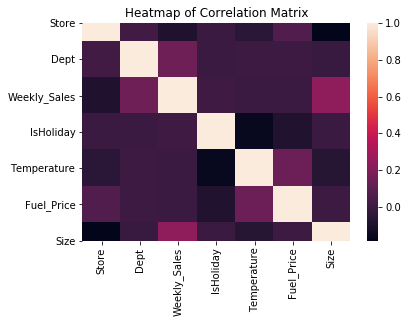

In [20]:
# Create a correlation matrix. What features correlate the most with Weekly_Sales?
# Helps to check if the numbering of stores or department or other features have any direct relation with the Weekly Sales

corr = train_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

# Based on the plot, there do not seem to be any strong correlation between Weekly Sales and a predictor.
# We need further investigation!

We have been given the three types of stores. Let's try to figure out what these types are.

Let us now see if the lack of correlation is due to Simpson's paradox. Let's divide the dataset into the two store types and check correlations again.

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,Size
Store,1.000000,0.008669,-0.123322,-0.000107,-0.138753,0.079593,-0.277718
Dept,0.008669,1.000000,0.241464,0.001294,0.004749,0.003361,-0.015384
Weekly_Sales,-0.123322,0.241464,1.000000,0.012483,-0.013339,-0.008223,0.166933
IsHoliday,-0.000107,0.001294,0.012483,1.000000,-0.160323,-0.076930,0.000377
Temperature,-0.138753,0.004749,-0.013339,-0.160323,1.000000,0.118630,-0.117188
Fuel_Price,0.079593,0.003361,-0.008223,-0.076930,0.118630,1.000000,-0.002761
Size,-0.277718,-0.015384,0.166933,0.000377,-0.117188,-0.002761,1.000000


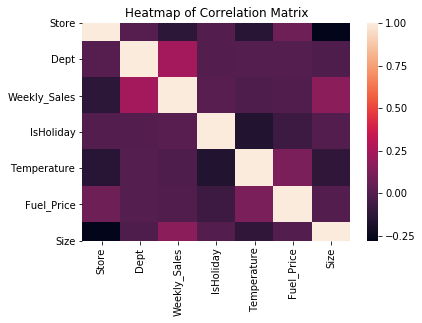

In [21]:
# Segregate the dataset for only type A stores. Create a correlation matrix. What features correlate the most with Weekly_Sales?
train_df_a = train_df[train_df['Type']=='A']

corr = train_df_a.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

# Based on the plot, there do not seem to be any strong correlation between Weekly Sales and a predictor.
# Let's look at type of store B

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,Size
Store,1.000000,0.013971,0.040039,-0.000237,-0.134050,0.078726,0.438762
Dept,0.013971,1.000000,-0.095832,0.000777,-0.008520,0.010950,0.015330
Weekly_Sales,0.040039,-0.095832,1.000000,0.017743,0.013341,0.041898,0.168339
IsHoliday,-0.000237,0.000777,0.017743,1.000000,-0.152010,-0.078078,-0.000732
Temperature,-0.134050,-0.008520,0.013341,-0.152010,1.000000,0.166674,0.032945
Fuel_Price,0.078726,0.010950,0.041898,-0.078078,0.166674,1.000000,0.156041
Size,0.438762,0.015330,0.168339,-0.000732,0.032945,0.156041,1.000000


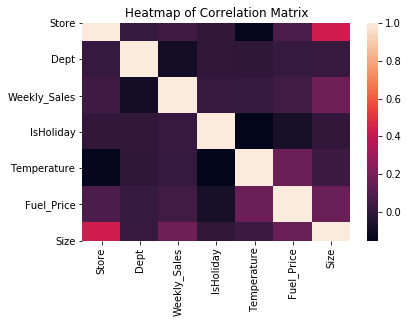

In [22]:
# Segregate the dataset for only type B stores. Create a correlation matrix. What features correlate the most with Weekly_Sales?
train_df_b = train_df[train_df['Type']=='B']

corr = train_df_b.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

# Based on the plot, there do not seem to be any strong correlation between Weekly Sales and a predictor.
# Let's look at type of store C

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,Size
Store,1.000000,-0.000498,0.022494,0.000443,-0.152797,0.077214,-0.695839
Dept,-0.000498,1.000000,0.396008,-0.000081,-0.002528,-0.012417,0.004384
Weekly_Sales,0.022494,0.396008,1.000000,0.000230,0.033590,-0.011570,0.017214
IsHoliday,0.000443,-0.000081,0.000230,1.000000,-0.169646,-0.086451,0.000218
Temperature,-0.152797,-0.002528,0.033590,-0.169646,1.000000,0.235278,0.030634
Fuel_Price,0.077214,-0.012417,-0.011570,-0.086451,0.235278,1.000000,-0.211497
Size,-0.695839,0.004384,0.017214,0.000218,0.030634,-0.211497,1.000000


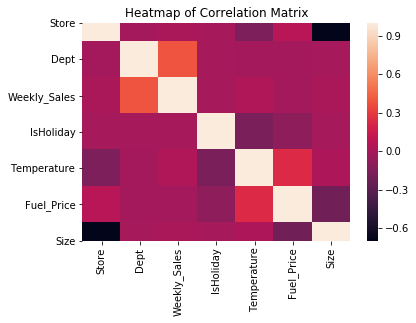

In [23]:
# Segregate the dataset for only type C stores. Create a correlation matrix. What features correlate the most with Weekly_Sales?
train_df_c = train_df[train_df['Type']=='C']

corr = train_df_c.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

# Based on the plot, there do not seem to be any strong correlation between Weekly Sales and a predictor.
# The correlation matrix has not revealed anything interesting

### Look for any trends for weekly sales averaging over each Store type

In [24]:
(train_df.groupby(['Type']).agg(['count','mean','median'])).Weekly_Sales

# We can see that the average sales within each store type are highly different with type A store sales being the highest.

,count,mean,median
Type,,,
A,215478,20099.568043,10105.17
B,163495,12237.075977,6187.87
C,42597,9519.532538,1149.67


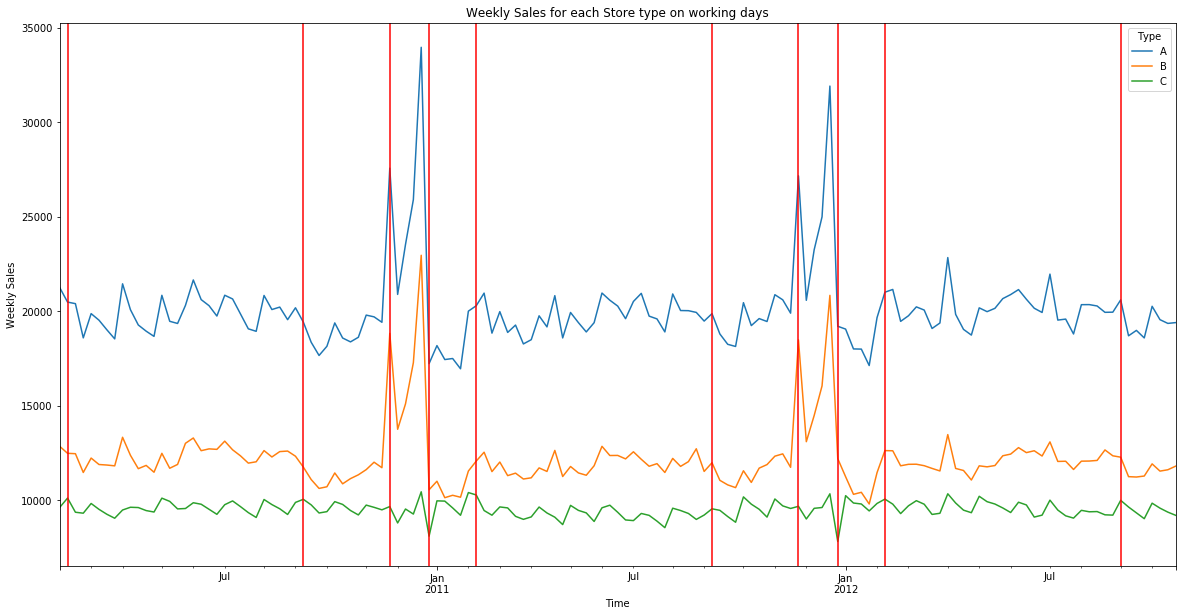

In [25]:
# Let's plot the average sales across each store type over time

grouped_type_date = train_df.groupby(['Type','Date'], as_index=False).mean()
type_date_sales = grouped_type_date.pivot(index = 'Date', columns='Type', values='Weekly_Sales')
ax = type_date_sales.plot(figsize = (20,10))
ax.set_xlabel("Time")
ax.set_ylabel("Weekly Sales")
ax.set_title("Weekly Sales for each Store type on working days")


# Let's also see what happens at the holidays. A vertical line is drawn at each holiday week.
for i in train_df[train_df['IsHoliday']==True].Date.unique():
    plt.axvline(i,color = 'r')


We can see that there are peaks associated with holidays, and it makes sense intuitively that there will be more sales around the holidays.

We can expect 'IsHolidays' feature to be very important!

Text(0.5, 1.0, 'Temperature over time')

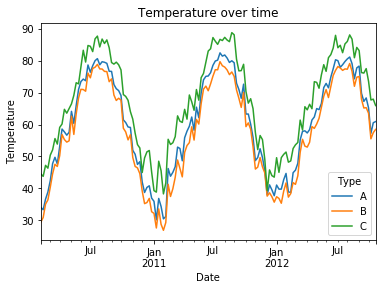

In [26]:
type_date_temperature = grouped_type_date.pivot(index = 'Date', columns='Type', values='Temperature')

ax1 = type_date_temperature.plot()
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature')
ax1.plot(type_date_temperature)
ax1.set_title('Temperature over time')


There seems to be no relation of the Temperature with the Weekly Sales visually and no variation within the different store types. We would not expect anything different from the Fuel Proce either but we can plot and confirm.

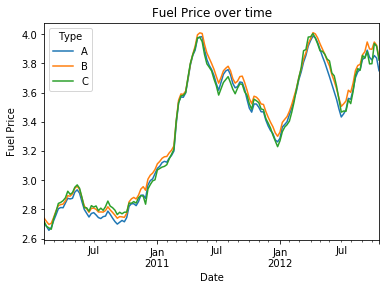

In [27]:
type_date_FP = grouped_type_date.pivot(index = 'Date', columns='Type', values='Fuel_Price')

ax1 = type_date_FP.plot()
ax1.set_xlabel('Date')
ax1.set_ylabel('Fuel Price')
ax1.plot(type_date_FP)
ax1.set_title('Fuel Price over time');

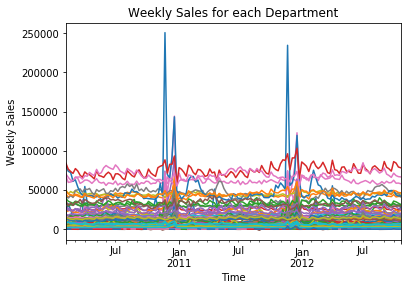

In [28]:
# Let's plot the average sales across each department type over time

grouped_dept_date = train_df.groupby(['Dept','Date'], as_index=False).mean()
dept_date_sales = grouped_dept_date.pivot(index = 'Date', columns='Dept', values='Weekly_Sales')
ax = dept_date_sales.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Weekly Sales")
ax.set_title("Weekly Sales for each Department")
ax.get_legend().remove()

Cannot find any interesting trend here as all departments do not show the same trend.

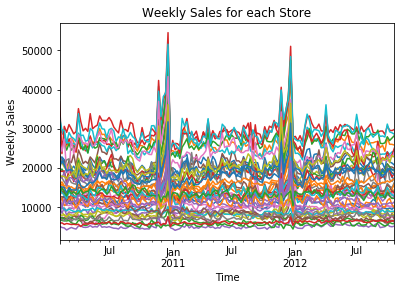

In [29]:
# Let's plot the average sales across each store type over time

grouped_store_date = train_df.groupby(['Store','Date'], as_index=False).mean()
dept_store_sales = grouped_store_date.pivot(index = 'Date', columns='Store', values='Weekly_Sales')
ax = dept_store_sales.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Weekly Sales")
ax.set_title("Weekly Sales for each Store")
ax.get_legend().remove()

Cannot find any interesting trend here although most stores show the same trend.

# Part 3

# Develop

## Hypothesize solutions

Since this is a prediction about sales as a functino of time, we can take this as a time-series problem.

The interesting thing about this dataset is that this is a multi-site time-series and there is also a possible realation between the departments of different stores. So, there are many ways to look at the problem and proceed. A few possible ways to go about it are:

a) Develop one model per department in each store: 
Again, this can be assumed as an univariate or multivariate model. This will yield a total of 3000+ models

b) Develop one model per group of stores and departments: 
We can group the departments into 3-4 types and then build a model for each store and department type. Given that there are 3 store types and assuming we further divide the department into 3 types, we can build upto 9 models following this method.

c) Develop one model for all stores and departments:
This is a very generic model with one model for all sites and departments. I can think of RNNs for doing this kind of model as they are very efficient in dealing with complex models.

d) Ensemble of the above:
One more possibility is combining all the three above methods to reduce variance and bias asspciated with each model to hopefully get better estimates.

The other method is to take it as a normal Machine Learning algorithm and build some model. We can possibly look into random forests, neural networks, xgboost,etc. 

## Model A (Time Series model)

Out of all the methods listed above, lets first try the univariate time series model for each department and store.

Since we are building a model for each department within a store, we cannot analyze and fit parameters for every model. We will therefore consider one department and assume that the same parameters work for each model. Though, this assumption is not perfect, it might be valid for most cases as the sales of most department are not vary similar to the sales of the store.

In [30]:
# Examine first set
store1_dept1 = train_df[(train_df['Store']==1) & (train_df['Dept']==1)]

# Since we are building models for each Store and Department seperately, we can remove 
# the features which are store specific to Store and Dept.
del store1_dept1['Store']
del store1_dept1['Dept']
del store1_dept1['Size']
del store1_dept1['Type']
# Make date the index of the dataframe and deelete the column.
store1_dept1.index = store1_dept1.Date
del store1_dept1['Date']

# Convert boolean variables to integers
store1_dept1.IsHoliday = store1_dept1.IsHoliday.astype(int)

First step is to find the p, d and q parameters of the time series.

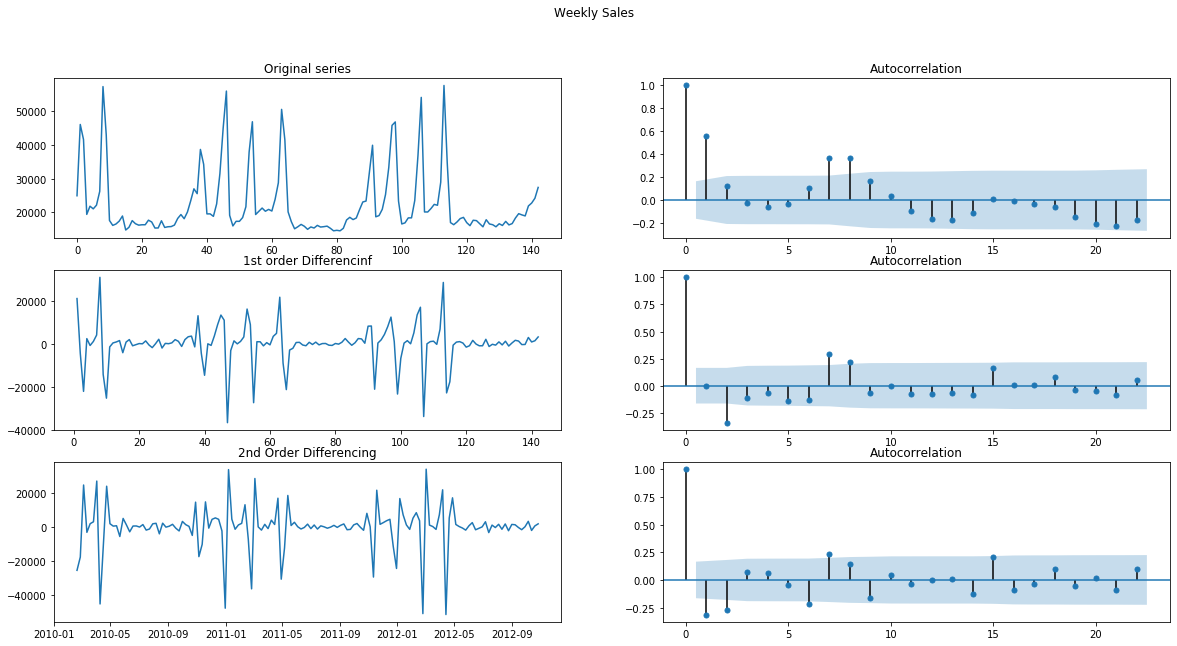

In [31]:
# Weekly Sales
f, ax = plt.subplots(3, 2, figsize=(20,10))
ax[0, 0].plot(store1_dept1.Weekly_Sales.values)
ax[0, 0].set_title('Original series')
plot_acf(pd.Series(store1_dept1.Weekly_Sales), ax=ax[0, 1])

# # Weekly Sales with 1st order differencing
ax[1, 0].plot(store1_dept1.Weekly_Sales.diff().values)
ax[1, 0].set_title('1st order Differencinf')
plot_acf(pd.Series(store1_dept1.Weekly_Sales.diff().dropna()), ax=ax[1, 1])

# Weekly Sales with 2 orders of differencing
ax[2, 0].plot(store1_dept1.index, store1_dept1.Weekly_Sales.diff().diff().values)
ax[2, 0].set_title('2nd Order Differencing')
plot_acf(store1_dept1.Weekly_Sales.diff().diff().dropna(), ax=ax[2, 1]);
f.suptitle('Weekly Sales');

From the plots shown, we can see that the 1st difference series is stationary. We can assume that the differencing is 1. d=1 and q=2. Also, we will ignore the seasonality keeping in mind that the data for many department is missing throughout the year.

We can find the Auto-regression parameter of the model p from the PACF plots of the differences of the series.

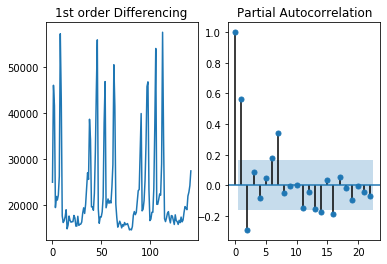

In [32]:
# Partial Autocorrelation plot for Weekly Sales.
f, ax = plt.subplots(1,2)
ax[0].plot(store1_dept1.Weekly_Sales.values)
ax[0].set_title('1st order Differencing')
plot_pacf(pd.Series(store1_dept1.Weekly_Sales), ax=ax[1]);

#  Let's fix the value at 2 for the AR term 'p'

The partial auto correlation factor suggests that the lag value of 2 seems to be appropriate. p=2

In [33]:
# creating the train and validation set
train = store1_dept1[:int(0.8*(len(store1_dept1)))]
valid = store1_dept1[int(0.8*(len(store1_dept1))):]

# Since the features are in different scales. Let's scale the dataframe (although there is no need in our case)
scaler = MinMaxScaler()
scaled_sales=scaler.fit_transform(train.Weekly_Sales.values.reshape(-1,1))

# Define the model based on the values of p, d and q we have decided.
model = ARIMA(endog = scaled_sales, order=(2,1,2),exog=train[['IsHoliday','Temperature','Fuel_Price']])
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  113
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  23.253
Method:                       css-mle   S.D. of innovations              0.193
Date:                Sun, 02 Feb 2020   AIC                            -28.506
Time:                        23:08:33   BIC                             -3.960
Sample:                    02-12-2010   HQIC                           -18.545
                         - 04-06-2012                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0320      0.040     -0.802      0.424      -0.110       0.046
IsHoliday       0.1225      0.126      0.973      0.333      -0.124       0.369
Temperature     0.0003      0.001      0.581    

We can see that the p-values for the coeffecients of the model AR1, MA1 and MA2 are quite low hsowing that the model coefficients are significant which is good. We can also note the high values of p for the variables Fuel Price, Temperature showing that they are not very important features


Let us now look at the prediction on the train and validations sets

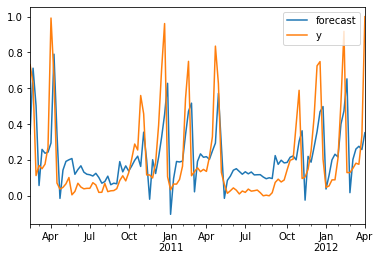

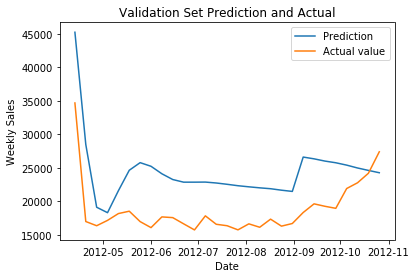

In [34]:
forecast, se, CI = model_fit.forecast(29, exog=valid[['IsHoliday','Temperature','Fuel_Price']], alpha=0.05)

# Model fit and the actual values on the training set
model_fit.plot_predict(dynamic=False);

# Model fit and the actual values on the validation set
fig, ax1 = plt.subplots()
ax1.plot(valid.index,scaler.inverse_transform(forecast.reshape(-1,1)),label='Prediction')
ax1.plot(valid.index,valid.Weekly_Sales,label='Actual value')
ax1.set_xlabel('Date')
ax1.set_ylabel('Weekly Sales')
ax1.title.set_text('Validation Set Prediction and Actual')
ax1.legend(loc="upper right");


Not a very impressive fit but thats the best we got from the limited data. Let's go ahead and build a modelfor each department and store.

In [172]:
# train_df_uv is the dataframe we will use for training the univariate model
train_df_uv = train_df.copy()

# Although not the correct way to do, we will scale the data based on average sales, 
# temperature and fuel prices of the entire data (to avoid calculating for each model).
scaler = MinMaxScaler()
scaler.fit(train_df_uv[['Weekly_Sales']])

# Make date the index of the dataframe and delete the date column.
train_df_uv.index = train_df_uv.Date
del train_df_uv['Date']

# Convert boolean variables to integers
train_df_uv.IsHoliday = train_df_uv.IsHoliday.astype(int)

In [186]:
# # Make a seperate model for each department within a store!
# # Loop through each of the 45 stores
# for store in range(1,46):
    
#     # Loop through each department within the store
#     for dept in range(1,100):
        
#         # seperate out the relevant data specific to the current store and dept.
#         training_set = train_df_uv[(train_df_uv['Store']==store) & (train_df_uv['Dept']==dept)]
        
#         # If the model has less than 3 points, it is too low to make model out of it.
#         # So, lets skip such cases!
#         if len(training_set)<3:
#             continue
        
#         # Since we are building models for each Store and Department seperately, we can remove 
#         # the features which are store specific to Store and Dept.
#         del training_set['Size']
#         del training_set['Type']
        
#         print(store,dept,len(training_set))
#         # Scale the training data
#         scaled_sales = scaler.fit_transform(training_set.Weekly_Sales.values.reshape(-1,1))
        
#         # Setup a model 
#         try:
#             model = ARIMA(endog = scaled_sales, order=(1,1,2), exog=training_set[['IsHoliday','Temperature', 'Fuel_Price']])
#             model_fit = model.fit(transparams=False, disp=0, trend = 'nc')

#         except:
#             model = ARIMA(endog = scaled_sales, order=(2,0,2), exog=training_set[['IsHoliday','Temperature','Fuel_Price']])
            
#             model_fit = model.fit(transparams=False, disp=0, trend = 'nc')

#         # Save the model
#         model_fit.save('./UV_models/UV_model_'+str(store)+'_'+str(dept)+'.pkl')


In [ ]:
# # Once we have completed building all the models, we can proceed to test the results.

# submission = pd.DataFrame(columns=['Id','Weekly_Sales'])

# # loop through each store 
# for store in range(1,2):
    
#     # And each department
#     for dept in range(1,2):
        
#         # Seperate out the forecas dats for that store and department
#         subframe = pd.DataFrame()
#         test_set = test_df[(test_df['Store']==store) & (test_df['Dept']==dept)]      
        
#         # We need not continue if there is nothing to predict for given store and department
#         if len(test_set)<1:
#             continue
            
# #         print(store, dept)
        
#         # Create the index as required in the output file
#         subframe['Id'] = test_set["Store"].map(str) + '_' + test_set["Dept"].map(str) +\
#                         '_' + test_set['Date'].dt.date.astype(str)
        
#         try:
            
#             # Load the model if have it. (Remember that we dont't have a model for
#             # small samples and if there is no training data)
#             loaded = ARIMAResults.load('./UV_models/UV_model_'+str(store)+'_'+str(dept)+'.pkl')

#             # Forecasted values can be added to the column 'Weekly Sales'
#             subframe['Weekly_Sales'], se, CI = model_fit.forecast(len(test_set), exog=\
#                                             test_set[['IsHoliday','Temperature','Fuel_Price']], alpha=0.05)

#             # And the values should be inverse transformed to the original scale
#             subframe['Weekly_Sales'] = scaler.inverse_transform(subframe['Weekly_Sales'].values.reshape(-1,1))
        
#         except:
#             # In case we don't have a model for the current store and department because of small sample size, 
#             # predict the next steps to be the mean of the sales of those values
#             subframe['Weekly_Sales'] = train_df_uv[(train_df_uv['Store']==store) & \
#                                                    (train_df_uv['Dept']==dept)].Weekly_Sales.mean()
            
#             # In case, there was no training data for the current store and department,
#             # predict the next steps to be average of the sales for department 
#             # across store of the same type
#             if subframe.isnull().values.any():
#                 subframe['Weekly_Sales'] = train_df[(train_df['Dept']==dept) & \
#                                             (train_df['Type']==test_set.Type.mode()[0])].Weekly_Sales.mean()
            
#             # In case, there is no data for that type at all, take the average of the sales
#             # for that department across every store
#             if subframe.isnull().values.any():
#                 subframe['Weekly_Sales'] = train_df[(train_df['Dept']==dept)].Weekly_Sales.mean()
        
#         # Append the results at the end
#         submission = submission.append(subframe,ignore_index=True)

# # submission.to_csv('submission.csv',index=False)

#### Auto Arima

Because of the varying amount of data for each store and department, I have realized that the same value of p,d and q parameters is giving out poor results. So, I decided to go with the autoarima method which chooses the best parameter od p, d and q automatically. 

We will use this method to fit a model for each department and store.

In [184]:
# Make a seperate model for each department within a store!
# Loop through each of the 45 stores
for store in range(1,46):
    
    # Loop through each department within the store
    for dept in range(1,100):
        
        # seperate out the relevant data specific to the current store and dept.
        training_set = train_df_uv[(train_df_uv['Store']==store) & (train_df_uv['Dept']==dept)]
        
        if len(training_set)<3:
            continue
        
        del training_set['Store']
        del training_set['Dept']
        
        # Scale the training data
        scaled_data = scaler.transform(training_set[['Weekly_Sales']])
        
        # Setup a model 
        model = pm.auto_arima(y = scaled_sales, exog=train[['IsHoliday','Temperature','Fuel_Price']],\
                             start_p=1, start_q=1, test='adf', max_p=3, max_q=3, d=None)
         
        # Save the model
        model_fit.save('./Auto_models/Auto_model_'+str(store)+'_'+str(dept)+'.pkl')


1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 40
1 41
1 42
1 44
1 45
1 46
1 47
1 48
1 49
1 51
1 52
1 54
1 55
1 56
1 58
1 59
1 60
1 67
1 71
1 72
1 74
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 85
1 87
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 44
2 45
2 46
2 47
2 48
2 49
2 51
2 52
2 54
2 55
2 56
2 58
2 59
2 60
2 67
2 71
2 72
2 74
2 78
2 79
2 80
2 81
2 82
2 83
2 85
2 87
2 90
2 91
2 92
2 93
2 94
2 95
2 96
2 97
2 98
2 99
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 38
3 40
3 41
3 42
3 44
3 45
3 46
3 47
3 49
3 51
3 52
3 54
3 55
3 56
3 59
3 60
3 

21 6
21 7
21 8
21 9
21 10
21 11
21 12
21 13
21 14
21 16
21 17
21 18
21 19
21 20
21 21
21 22
21 23
21 24
21 25
21 26
21 27
21 28
21 29
21 30
21 31
21 32
21 33
21 34
21 35
21 36
21 38
21 40
21 41
21 42
21 44
21 45
21 46
21 47
21 49
21 51
21 52
21 54
21 55
21 56
21 58
21 59
21 60
21 67
21 71
21 72
21 74
21 78
21 79
21 80
21 81
21 82
21 83
21 85
21 87
21 90
21 91
21 92
21 93
21 94
21 95
21 97
21 98
22 1
22 2
22 3
22 4
22 5
22 6
22 7
22 8
22 9
22 10
22 11
22 12
22 13
22 14
22 16
22 17
22 18
22 19
22 20
22 21
22 22
22 23
22 24
22 25
22 26
22 27
22 28
22 29
22 30
22 31
22 32
22 33
22 34
22 35
22 36
22 38
22 40
22 41
22 42
22 44
22 45
22 46
22 47
22 48
22 49
22 51
22 52
22 54
22 55
22 56
22 58
22 59
22 60
22 67
22 71
22 72
22 74
22 77
22 78
22 79
22 80
22 81
22 82
22 83
22 85
22 87
22 90
22 91
22 92
22 93
22 94
22 95
22 96
22 97
22 98
23 1
23 2
23 3
23 4
23 5
23 6
23 7
23 8
23 9
23 10
23 11
23 12
23 13
23 14
23 16
23 17
23 18
23 19
23 20
23 21
23 22
23 23
23 24
23 25
23 26
23 27
23 28
23 29
23

40 47
40 48
40 49
40 51
40 52
40 54
40 55
40 56
40 58
40 59
40 60
40 67
40 71
40 72
40 74
40 77
40 79
40 80
40 81
40 82
40 83
40 85
40 87
40 90
40 91
40 92
40 93
40 94
40 95
40 96
40 97
40 98
40 99
41 1
41 2
41 3
41 4
41 5
41 6
41 7
41 8
41 9
41 10
41 11
41 12
41 13
41 14
41 16
41 17
41 18
41 19
41 20
41 21
41 22
41 23
41 24
41 25
41 26
41 27
41 28
41 29
41 30
41 31
41 32
41 33
41 34
41 35
41 36
41 38
41 40
41 41
41 42
41 44
41 45
41 46
41 47
41 48
41 49
41 51
41 52
41 54
41 55
41 56
41 58
41 59
41 60
41 67
41 71
41 72
41 74
41 77
41 78
41 79
41 80
41 81
41 82
41 83
41 85
41 87
41 90
41 91
41 92
41 93
41 94
41 95
41 96
41 97
41 98
41 99
42 1
42 2
42 3
42 4
42 5
42 6
42 7
42 8
42 9
42 10
42 11
42 12
42 13
42 14
42 16
42 17
42 18
42 20
42 21
42 22
42 23
42 24
42 25
42 26
42 27
42 28
42 31
42 32
42 33
42 38
42 40
42 42
42 44
42 46
42 49
42 52
42 55
42 56
42 59
42 60
42 67
42 71
42 72
42 74
42 79
42 80
42 81
42 82
42 83
42 85
42 87
42 90
42 91
42 92
42 93
42 94
42 95
42 96
42 97
42 98
43 1

In [185]:
# Once we have completed building all the models, we can proceed to test the results.

submission = pd.DataFrame(columns=['Id','Weekly_Sales'])

# loop through each store 
for store in range(1,46):
    
    # And each department
    for dept in range(1,100):
        
        # Seperate out the forecas dats for that store and department
        subframe = pd.DataFrame()
        test_set = test_df[(test_df['Store']==store) & (test_df['Dept']==dept)]      
        
        # We need not continue if there is nothing to predict for given store and department
        if len(test_set)<1:
            continue
                    
        # Create the index as required in the output file
        subframe['Id'] = test_set["Store"].map(str) + '_' + test_set["Dept"].map(str) +\
                        '_' + test_set['Date'].dt.date.astype(str)
        
        try:
            
            # Load the model if have it. (Remember that we dont't have a model for
            # small samples and if there is no training data)
            with open('./Auto_models/Auto_model_'+str(store)+'_'+str(dept)+'.pkl', 'rb') as f:
                model_fit = pickle.load(f)

            # Forecasted values can be added to the column 'Weekly Sales'
            subframe['Weekly_Sales'], se, CI = model_fit.forecast(len(test_set), exog=\
                                            test_set[['IsHoliday','Temperature','Fuel_Price']], alpha=0.05)

            # And the values should be inverse transformed to the original scale
            subframe['Weekly_Sales'] = scaler.inverse_transform(subframe['Weekly_Sales'].values.reshape(-1,1))
        
        except:
            # In case we don't have a model for the current store and department because of small sample size, 
            # predict the next steps to be the mean of the sales of those values
            subframe['Weekly_Sales'] = train_df_uv[(train_df_uv['Store']==store) & \
                                                   (train_df_uv['Dept']==dept)].Weekly_Sales.mean()
            
            # In case, there was no training data for the current store and department,
            # predict the next steps to be average of the sales for department 
            # across store of the same type
            if subframe.isnull().values.any():
                subframe['Weekly_Sales'] = train_df[(train_df['Dept']==dept) & \
                                            (train_df['Type']==test_set.Type.mode()[0])].Weekly_Sales.mean()
            
            # In case, there is no data for that type at all, take the average of the sales
            # for that department across every store
            if subframe.isnull().values.any():
                subframe['Weekly_Sales'] = train_df[(train_df['Dept']==dept)].Weekly_Sales.mean()
        
        # Append the results at the end
        submission = submission.append(subframe,ignore_index=True)

submission.to_csv('submission.csv',index=False)

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 40
1 41
1 42
1 44
1 45
1 46
1 47
1 48
1 49
1 52
1 54
1 55
1 56
1 58
1 59
1 60
1 67
1 71
1 72
1 74
1 79
1 80
1 81
1 82
1 83
1 85
1 87
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 40
2 41
2 42
2 44
2 45
2 46
2 47
2 48
2 49
2 52
2 54
2 55
2 56
2 58
2 59
2 60
2 67
2 71
2 72
2 74
2 77
2 79
2 80
2 81
2 82
2 83
2 85
2 87
2 90
2 91
2 92
2 93
2 94
2 95
2 96
2 97
2 98
2 99
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 38
3 40
3 41
3 42
3 44
3 46
3 47
3 49
3 52
3 54
3 55
3 56
3 59
3 60
3 67
3 71
3 72
3 74
3 79
3 80
3 81
3 

21 55
21 56
21 58
21 59
21 60
21 67
21 71
21 72
21 74
21 79
21 80
21 81
21 82
21 83
21 85
21 87
21 90
21 91
21 92
21 93
21 94
21 95
21 97
21 98
21 99
22 1
22 2
22 3
22 4
22 5
22 6
22 7
22 8
22 9
22 10
22 11
22 12
22 13
22 14
22 16
22 17
22 18
22 19
22 20
22 21
22 22
22 23
22 24
22 25
22 26
22 27
22 28
22 29
22 30
22 31
22 32
22 33
22 34
22 35
22 36
22 38
22 40
22 41
22 42
22 44
22 46
22 47
22 49
22 52
22 54
22 55
22 56
22 58
22 59
22 60
22 67
22 71
22 72
22 74
22 79
22 80
22 81
22 82
22 83
22 85
22 87
22 90
22 91
22 92
22 93
22 94
22 95
22 96
22 97
22 98
23 1
23 2
23 3
23 4
23 5
23 6
23 7
23 8
23 9
23 10
23 11
23 12
23 13
23 14
23 16
23 17
23 18
23 19
23 20
23 21
23 22
23 23
23 24
23 25
23 26
23 27
23 28
23 29
23 30
23 31
23 32
23 33
23 34
23 35
23 36
23 38
23 40
23 41
23 42
23 44
23 45
23 46
23 47
23 49
23 50
23 52
23 54
23 55
23 56
23 58
23 59
23 60
23 67
23 71
23 72
23 74
23 79
23 80
23 81
23 82
23 83
23 85
23 87
23 90
23 91
23 92
23 93
23 94
23 95
23 96
23 97
23 98
23 99
24 1
24 2


41 71
41 72
41 74
41 79
41 80
41 81
41 82
41 83
41 85
41 87
41 90
41 91
41 92
41 93
41 94
41 95
41 96
41 97
41 98
41 99
42 1
42 2
42 3
42 4
42 5
42 6
42 7
42 8
42 9
42 10
42 11
42 12
42 13
42 14
42 16
42 17
42 18
42 20
42 21
42 22
42 23
42 24
42 25
42 26
42 27
42 28
42 30
42 31
42 32
42 33
42 38
42 40
42 42
42 44
42 46
42 49
42 52
42 55
42 56
42 59
42 60
42 67
42 72
42 74
42 79
42 80
42 81
42 82
42 83
42 85
42 87
42 90
42 91
42 92
42 93
42 94
42 95
42 96
42 97
42 98
43 1
43 2
43 3
43 4
43 5
43 6
43 7
43 8
43 9
43 10
43 11
43 12
43 13
43 14
43 16
43 17
43 18
43 20
43 21
43 22
43 23
43 25
43 26
43 28
43 31
43 32
43 33
43 38
43 40
43 42
43 46
43 49
43 52
43 55
43 56
43 59
43 60
43 67
43 71
43 72
43 74
43 79
43 80
43 81
43 82
43 83
43 85
43 87
43 90
43 91
43 92
43 93
43 94
43 95
43 96
43 97
43 98
44 1
44 2
44 3
44 4
44 5
44 6
44 7
44 8
44 9
44 10
44 11
44 12
44 13
44 14
44 16
44 17
44 18
44 20
44 21
44 22
44 23
44 24
44 25
44 26
44 27
44 28
44 31
44 32
44 33
44 38
44 40
44 42
44 44
44 46
4

Now that we have built a time series model. Let us consider if building a normal Machine Learning supervised techniques like neural network, XGBoost and Random Forest are useful or not. Let us have a look at the Weekly Sales 

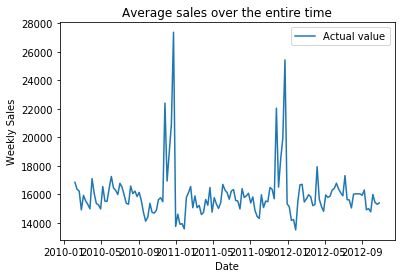

In [36]:
# plot avaerage sales across all stores

avg_sales_date = train_df.groupby('Date').Weekly_Sales.mean()

fig, ax1 = plt.subplots()
ax1.plot(train_df.groupby('Date').Weekly_Sales.mean(),label='Actual value')
ax1.set_xlabel('Date')
ax1.set_ylabel('Weekly Sales')
ax1.title.set_text('Average sales over the entire time')
ax1.legend(loc="upper right");

From the above plot, we can see that there is no visible trend in the data. The reason why most ML algorithms fail for time series is due to there inability to predict trend as there is no data drom the future. Neural networks are an exception to this rule in general and might be effective for neural networks in some cases.

But in our case, there is no visible trend in the data and seasonality should not be a problem if we can split the date into features of day and month. This will help the algorithm capture the seasonality of the data. For example, if we add month as a feature, the algortihm can understand that the sales will have a spike in months of November and December around Thanksgiving. 

In our data, we have variables Store and Data with datatype as integer. But these are not ordinal variables and actually categorical. Doing one hot encoding for these many different stores and departments is not feasible. 

Neural networks tend to approximate the target variable by using a complex function. So, more often than not, the target variable will be a smooth function of the inputs. But, since we are using store and department as an ordinal variable instead of categorical variable, neural netwerok might not perform very well. Random Forest on the other hand would not have problems dealing with this as they can effectively convert even a continuous variable into a categorical variable.

So, specifically, for this data, I expect Random Forest to perform better than neural networks. 

### Model B

### Random Forest

In [108]:
class model_rf(object):
    
    def __init__(self, n_estimators=100,max_features='log2', verbose=1):
        
        # Default setting of the Random Forest
        self.RF = RandomForestRegressor(n_estimators=100, verbose=1)

    # fitting the model with the  cols name specified as the target variable
    def fit(self,data_frame, cols):
        self.cols=cols
        self.RF.fit(data_frame.drop(cols,axis=1),data_frame[cols])
        self.fitted_value = self.predict(data_frame.drop(cols,axis=1))

    # predicts the target variable given the dataframe. inplace arguments adds the target variable as a column.
    def predict(self,data_frame, inplace=False):
        prediction = self.RF.predict(data_frame)
        if inplace:
            data_frame[self.cols] = prediction
            return data_frame
        return prediction


In [ ]:
tra

As described above, we need to do feature engineering to seperate out Date and Month from Date

Let's fit the model for one store and department and check if random forest works well.

In [65]:
# Seperate out the dataframe to create a sample for first department in first store.
store1_dept1 = train_df[(train_df['Store']==1) & (train_df['Dept']==1)]

# Adding a feature of month to the dataframe
store1_dept1['Month'] = pd.to_datetime(store1_dept1['Date']).dt.month

# Delete the date feature
del store1_dept1['Date']

# Type becomes a redundant feature since we have store and department as variables already.
del store1_dept1['Type']

# Seperate the dataset into train and validation
train = store1_dept1[:int(0.8*(len(store1_dept1)))]
valid = store1_dept1[int(0.8*(len(store1_dept1))):]

In [89]:
# Define the model
Random_Forest = model_rf()

# Fit the model
Random_Forest.fit(train,['Weekly_Sales'])

# predict on the entire set including the validation set
prediction = Random_Forest.predict(store1_dept1.drop(['Weekly_Sales'],axis=1))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


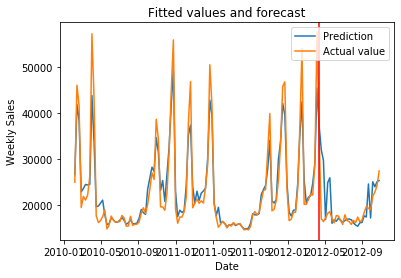

In [40]:
# Model fit and the actual values on the validation set
fig, ax1 = plt.subplots()
ax1.plot(train_df.Date[:143], prediction,label='Prediction')
ax1.plot(train_df.Date[:143], store1_dept1.Weekly_Sales.values[:143],label='Actual value')
ax1.set_xlabel('Date')
ax1.set_ylabel('Weekly Sales')
ax1.title.set_text('Fitted values and forecast')
ax1.legend(loc="upper right")

# The validation forecast is to the right of red line
plt.axvline(train_df.Date[114],color = 'r');


Rndom Forest seems to be doing well.

Now, let's build a model on the entire dataset and do hyperparameter tuning

In [85]:
# Create a copy of the original dataframe for random forest fitting
train_rf = train_df.copy()

# Adding a feature of month to the dataframe
train_rf['Month'] = pd.to_datetime(train_rf['Date']).dt.month

# Type becomes a redundant feature since we have store and department as variables already.
del train_rf['Type']


### Fixed validation set

Unlike the normal model building setup, we cannot use k-fold cross validation or random shuffle and form validation set. This is because our algorithm needs to work in the future for data which has not been seen. So, we need to have training data for the past and validation set needs to be for future data.

So, we split the train set based on date to form the validation set.

In [95]:
train_val_split = (train_rf['Date']<'2012-01-06').values.astype(int)

del train_rf['Date']

In [43]:
# Define the model
Random_Forest = model_rf()

# Create the random grid
random_grid = {'n_estimators': [30, 50, 100],
               'max_features': ['auto','sqrt'],
               'max_depth': [50, 100]}

RF_random = GridSearchCV(estimator = Random_Forest.RF, param_grid = random_grid, verbose=1,cv = list(PredefinedSplit\
                        (train_val_split).split(train_rf.drop(['Weekly_Sales'],axis=1),train_rf['Weekly_Sales'])))


In [44]:
RF_random.fit(train_rf.drop(['Weekly_Sales'],axis=1),train_rf['Weekly_Sales'])

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   25.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_j

GridSearchCV(cv=[(array([     0,      1,      2, ..., 421524, 421525, 421526]),
                  array([   100,    101,    102, ..., 421567, 421568, 421569])),
                 (array([   100,    101,    102, ..., 421567, 421568, 421569]),
                  array([     0,      1,      2, ..., 421524, 421525, 421526]))],
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='log2',
                                             max_leaf_nodes=None,
                                             min_im...
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                       

We can now redefine the model with the best parameters and use it on the entire dataset.

In [45]:
RF_random.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=1, warm_start=False)

We now define the default model as thie best estimator

In [142]:
class model_rf(object):
    
    def __init__(self, n_estimators=50,max_depth=50, max_features='log2'):
        
        # Default setting of the Random Forest
        self.RF = RandomForestRegressor(n_estimators=n_estimators, max_depth= max_depth, max_features= max_features)

    # fitting the model with the  cols name specified as the target variable
    def fit(self,data_frame, cols):
        self.cols=cols
        self.RF.fit(data_frame.drop(cols,axis=1),data_frame[cols])
        self.fitted_value = self.predict(data_frame.drop(cols,axis=1))

    # predicts the target variable given the dataframe. inplace arguments adds the target variable as a column.
    def predict(self,data_frame, inplace=False):
        prediction = self.RF.predict(data_frame)
        if inplace:
            data_frame[self.cols] = prediction
            return data_frame
        return prediction


In [143]:
# Modifying the test data as needed
test_rf = test_df.copy()

# Adding a feature of month to the dataframe
test_rf['Month'] = pd.to_datetime(test_rf['Date']).dt.month
del test_rf['Date']

del test_rf['Type']


In [145]:
# Building the model
Random_Forest = model_rf()

# Fitting the model
Random_Forest.fit(train_rf, ['Weekly_Sales'])

# Predicions on the test set
prediction = Random_Forest.predict(test_rf)

In [114]:
# creating a submission file
submission = pd.DataFrame()
submission['Id'] = test_data["Store"].map(str) + '_' + test_data["Dept"].map(str) +\
                        '_' + test_data['Date'].dt.date.astype(str)
submission['Weekly_Sales'] = prediction
submission.to_csv('submission_rf.csv',index=False)

### Model C
### XGBoost

In [37]:
class model_xgb(object):
    
    def __init__(self):
        
        # default setting of the XGBoost 
        self.xgb_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,\
                                       learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
    
    # fitting the model with the  cols name specified as the target variable
    def fit(self,data_frame, cols):
        self.cols=cols
        self.xgb_reg.fit(data_frame.drop(cols,axis=1),data_frame[cols])

    # predicts the target variable given the dataframe. inplace arguments adds the target variable as a column.
    def predict(self,data_frame, inplace=False):
        prediction = self.xgb_reg.predict(data_frame)
        if inplace:
            data_frame[self.cols] = prediction
            return data_frame
        return prediction

In [150]:
# Create a copy of the original dataframe for random forest fitting
train_xgb = train_df.copy()

# Adding a feature of month to the dataframe
train_xgb['Month'] = pd.to_datetime(train_xgb['Date']).dt.month

# Type becomes a redundant feature since we have store and department as variables already.
del train_xgb['Type']

train_val_split = (train_xgb['Date']<'2012-01-06').values.astype(int)

del train_xgb['Date']

In [152]:
# Define the model
XGB = model_xgb()

# Create the random grid
random_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2],
        'max_depth': [3, 4]
        }

xgb_random = GridSearchCV(estimator = XGB.xgb_reg, n_jobs=-1, param_grid = random_grid, verbose=1,cv = list(PredefinedSplit\
                        (train_val_split).split(train_rf.drop(['Weekly_Sales'],axis=1),train_rf['Weekly_Sales'])))


In [153]:
xgb_random.fit(train_xgb.drop(['Weekly_Sales'],axis=1),train_xgb['Weekly_Sales'])

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   41.2s finished


[02:30:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=[(array([     0,      1,      2, ..., 421524, 421525, 421526]),
                  array([   100,    101,    102, ..., 421567, 421568, 421569])),
                 (array([   100,    101,    102, ..., 421567, 421568, 421569]),
                  array([     0,      1,      2, ..., 421524, 421525, 421526]))],
             error_score='raise-deprecating',
             estimator=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.3,...
                                    min_child_weight=1, missing=None,
                                    n_estimators=10, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1

In [154]:
xgb_random.best_estimator_

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [156]:
class model_xgb(object):
    
    def __init__(self):
        
        # default setting of the XGBoost 
        self.xgb_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, min_child_weight = 1, gamma=0.5,\
                                        max_depth = 4, learning_rate = 0.1, alpha = 10, n_estimators = 10)
    
    # fitting the model with the  cols name specified as the target variable
    def fit(self,data_frame, cols):
        self.cols=cols
        self.xgb_reg.fit(data_frame.drop(cols,axis=1),data_frame[cols])

    # predicts the target variable given the dataframe. inplace arguments adds the target variable as a column.
    def predict(self,data_frame, inplace=False):
        prediction = self.xgb_reg.predict(data_frame)
        if inplace:
            data_frame[self.cols] = prediction
            return data_frame
        return prediction

In [157]:
# Modifying the test data as needed
test_xgb = test_df.copy()

# Adding a feature of month to the dataframe
test_xgb['Month'] = pd.to_datetime(test_xgb['Date']).dt.month
del test_xgb['Date']

del test_xgb['Type']


In [158]:
# Building the model
XGBoost = model_xgb()

# Fitting the model
XGBoost.fit(train_xgb, ['Weekly_Sales'])

# Predicions on the test set
prediction_xgb = XGBoost.predict(test_xgb)

[02:39:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [159]:
# creating a submission file
submission = pd.DataFrame()
submission['Id'] = test_data["Store"].map(str) + '_' + test_data["Dept"].map(str) +\
                        '_' + test_data['Date'].dt.date.astype(str)
submission['Weekly_Sales'] = prediction
submission.to_csv('submission_xgb.csv',index=False)

## Model D

### Neural Networks

In [406]:
# Create a copy of the original dataframe for neural network
train_nn = train_df.copy()

# Adding a feature of month to the dataframe
train_nn['Month'] = pd.to_datetime(train_nn['Date']).dt.month

# Type becomes a redundant feature since we have store and department as variables already.
del train_nn['Type']

del train_nn['Date']

In [407]:
class Data_scaler(object):
    
    def __init__(self, data_frame : pd.DataFrame, cols : list):
        """
        Takes in the dataframe and the list with column names that need to be scaled
        """
        self.data = data_frame[cols]
        self.min_data = np.min(self.data)
        self.max_data = np.max(self.data)
        self.cols = cols
    
    # Scales down the values in the dataframe.
    def transform_data(self, data_frame_to_scale):
        data_frame_to_scale[self.cols] = (data_frame_to_scale[self.cols] - self.min_data)/(self.max_data-self.min_data)
        return data_frame_to_scale
    
    # inverse scales the values in the dataframe
    def inverse_transform_data(self, data_frame_to_inv):
        data_frame_to_inv[self.cols] = data_frame_to_inv[self.cols]*(self.max_data-self.min_data)+self.min_data
        return data_frame_to_inv
    

In [408]:
# Scaling the training data
scaler = Data_scaler(train_nn, cols=['Temperature','Fuel_Price','Size'])

scaler.transform_data(train_nn)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,Size,Month
0,1,1,24924.50,False,0.434149,0.050100,0.630267,2
1,1,1,46039.49,True,0.396967,0.038076,0.630267,2
2,1,1,41595.55,False,0.410861,0.021042,0.630267,2
3,1,1,19403.54,False,0.476419,0.044589,0.630267,2
4,1,1,21827.90,False,0.475147,0.076653,0.630267,3
...,...,...,...,...,...,...,...,...
421565,45,98,508.37,False,0.654990,0.764028,0.451136,9
421566,45,98,628.10,False,0.655088,0.758016,0.451136,10
421567,45,98,1061.02,False,0.553131,0.765531,0.451136,10
421568,45,98,760.01,False,0.572701,0.750000,0.451136,10


In [409]:
class model_nn(object):
    
    def __init__(self, layers=[7, 50, 50, 50, 1]):
        
        self.model = keras.Sequential([
        keras.layers.Dense(units=7, activation='relu', input_shape=[7]),
        keras.layers.Dense(units=50, activation='relu'),
        keras.layers.Dense(units=50, activation='relu'),
        keras.layers.Dense(units=50, activation='relu'),
        keras.layers.Dense(units=1)])
        
        # Set up the optimizer
        optimizer = tf.keras.optimizers.Adam(0.01)

        # Regeression problem, so mse is a fair loss criterion
        self.model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae', 'mse'])

    # fitting the model with the  cols name specified as the target variable
    def fit(self,data_frame, cols):
        epochs = 10
        self.model.fit(
          data_frame.drop(cols,axis=1), data_frame[cols], epochs=epochs, verbose=1)
        
    # predictions from the neural network
    def predict(self, data_frame):
        """
        Forward propogation of the Neural Network
        """
        return self.model.predict(data_frame)

In [410]:
# building the model
nn = model_nn()

# fitting the model
nn.fit(train_nn, ['Weekly_Sales'])


Train on 421570 samples
Epoch 1/10
421570/421570 [==============================] - 26s 62us/sample - loss: 420536610.8088 - mae: 12933.9102 - mse: 420536640.0000
Epoch 2/10
421570/421570 [==============================] - 25s 59us/sample - loss: 384176829.9822 - mae: 12176.0127 - mse: 384175936.0000
Epoch 3/10
421570/421570 [==============================] - 28s 66us/sample - loss: 373963812.4528 - mae: 11896.4404 - mse: 373964256.0000
Epoch 4/10
421570/421570 [==============================] - 28s 67us/sample - loss: 378532417.9323 - mae: 11991.2920 - mse: 378532416.0000
Epoch 5/10
421570/421570 [==============================] - 26s 61us/sample - loss: 388303737.0204 - mae: 12213.2900 - mse: 388305664.0000
Epoch 6/10
421570/421570 [==============================] - 28s 67us/sample - loss: 384693039.8688 - mae: 12134.1621 - mse: 384692416.0000
Epoch 7/10
421570/421570 [==============================] - 26s 62us/sample - loss: 386826939.4286 - mae: 12207.5400 - mse: 386827264.0000
Epo

In [411]:
# Modifying the test data as needed
test_nn = test_df.copy()

# Adding a feature of month to the dataframe
test_nn['Month'] = pd.to_datetime(test_nn['Date']).dt.month
del test_nn['Date']

del test_nn['Type']

#Scaling the test data
test_nn = scaler.transform_data(test_nn)

# predictions from the model
prediction_nn = nn.predict(test_nn.values.astype(float))

In [412]:
# creating a submission file
submission = pd.DataFrame()
submission['Id'] = test_data["Store"].map(str) + '_' + test_data["Dept"].map(str) +\
                        '_' + test_data['Date'].dt.date.astype(str)
submission['Weekly_Sales'] = prediction_nn
submission.to_csv('submission_nn.csv',index=False)

Neural networks performance has been poor (True, it has not been optimized and hyperparameter have been not tuned). But as mentioned previously, we never expected neural networks to do well for this kind of data. And doing any amount of tuning will not make it better than Random Forest. So, we leave it as it is.

In [413]:
# one function to build and fit any method at once.
def fit_model(model_type: str,
             df_tr: pd.DataFrame,
             cols: list):
        
    if model_type == 'xgb':
        # Building the model
        XGBoost = model_xgb()
        # Fitting the model
        XGBoost.fit(df_tr, cols)
        return XGBoost
    
    elif model_type == 'rf':
        # Building the model
        Random_Forest = model_rf()
        # Fitting the model
        Random_Forest.fit(df_tr, cols)
        return Random_Forest

    elif model_type == 'nn':
        # Building the model
        Neural_Network = model_nn()
        
        # Fitting the model
        Neural_Network.fit(df_tr, cols)
        return Neural_Network
    
    else:
        raise KeyError('Incorrect model type is given: {}'.format(model_type))

# Part 4

# Deploy

N/A

## Summary

I have defined the problem statement of forecasting the sales into the future. 

I explored the data and tried to see any correlations and intuitive check to see if any feature ingineering can be done.

I then hypothesized the solution and built models on what we believe might be the best starting from time series. After looking at the performance and further thinking, I realized that Random Forest and XGBoost might be good models for this kind of data. I built a Random Forest model and did hyperparamter tuning with a predefined validation set (very important to do this for time-series data). Repeated the same method for XGBoost. 

A neural network model was built as well knowing that it might not perform very well. And the results matched the discussions I wrote earlier.

Further work can definitely be done to improve the model:
a) can check if we can fit a LSTM to the data. 
b) an ensemble model can be built
c) a multi-model of time series can be built (as written previously when discussing time series).
d) I have neglected some features intuitively which can be added to the model and check again if I was wrong.